In [9]:
import numpy
import pandas
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pandas.read_json("../datasets/joke_info.json")
df

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText
0,RE5tz52q,1,8,0,reddit,5tz52q,I hate how you cant even say black paint anymo...
1,RE5tz4dd,1,8,0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...
2,RE5tz319,0,9,8,reddit,5tz319,I recently went to America....\n...and being t...
3,RE5tz2wj,3,9,0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave..."
4,RE5tz1pc,5,3,8,reddit,5tz1pc,You hear about the University book store worke...
...,...,...,...,...,...,...,...
186,SS200,8,10,4,stupidstuff,200,A concerned husband went to a doctor to talk a...
187,SS5,0,0,0,stupidstuff,5,A girl came skipping home FROM school one day....
188,SS6,0,0,0,stupidstuff,6,An airline captain was helping a new blonde fl...
189,SS7,0,0,0,stupidstuff,7,A blonde and a brunette decided to rob a bank....


In [4]:
# get the first row's joke text
text = df.iloc[0]['jokeText']
text

'I hate how you cant even say black paint anymore\nNow I have to say "Leroy can you please paint the fence?"'

In [8]:
classifier = pipeline("sentiment-analysis", model="michellejieli/NSFW_text_classification")
classifier(text)

OSError: michellejieli/NSFW_text_classification is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [5]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)
print(pipeline(text))

[{'label': 'non-toxic', 'score': 0.94920414686203}]


In [6]:
model_path = "michellejieli/NSFW_text_classification"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)
print(pipeline(text))

OSError: michellejieli/NSFW_text_classification is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")
pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)
print(pipeline(text))

[{'label': 'toxic', 'score': 0.08247387409210205}]


In [11]:
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
softmax = torch.softmax(logits, dim=1)
predicted_probabilities = softmax.detach().numpy()[0]
predicted_probabilities


array([0.9487572 , 0.00194022, 0.0174638 , 0.00680512, 0.0145325 ,
       0.01050113], dtype=float32)

In [12]:
predicted_label_index = predicted_probabilities.argmax()
predicted_label_index

0

In [17]:
label_names = list(model.config.id2label.values())
label_names

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [18]:
predicted_label = label_names[predicted_label_index]
predicted_label

'toxic'

In [ ]:
# make a column in df for each label in label_names 
for label in label_names:
    df[label] = 0

df


In [23]:
# and fill it with the predicted probability for each row
def assign_labels(model, df, label_names):
    for index, row in df.iterrows():
        text = row['jokeText']
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        softmax = torch.softmax(logits, dim=1)
        predicted_probabilities = softmax.detach().numpy()[0]
        for i, label in enumerate(label_names):
            df.at[index, label] = predicted_probabilities[i]
    return df

Models :  Link
'unitary/toxic-bert' : https://huggingface.co/unitary/toxic-bert
'michellejieli/emotion_text_classifier':  https://huggingface.co/michellejieli/emotion_text_classifier

In [24]:
for model_path in ['unitary/toxic-bert', 'michellejieli/emotion_text_classifier']:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    label_names = list(model.config.id2label.values())
    df = assign_labels(model, df, label_names)
    

In [25]:
df

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,toxic,severe_toxic,obscene,threat,insult,identity_hate,anger,disgust,fear,joy,neutral,sadness,surprise
0,RE5tz52q,1,8,0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0.948757,0.001940,0.017464,0.006805,0.014533,0.010501,0.061078,0.877237,0.007832,0.003182,0.035944,0.006267,0.008462
1,RE5tz4dd,1,8,0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0.740485,0.004393,0.015876,0.007097,0.028220,0.203930,0.002969,0.014989,0.029352,0.001861,0.020232,0.835095,0.095502
2,RE5tz319,0,9,8,reddit,5tz319,I recently went to America....\n...and being t...,0.713799,0.033521,0.078657,0.038982,0.074032,0.061007,0.293198,0.003329,0.008355,0.498788,0.141473,0.008533,0.046325
3,RE5tz2wj,3,9,0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0.863763,0.006648,0.044527,0.011941,0.042326,0.030795,0.013720,0.017939,0.012250,0.079466,0.812853,0.001028,0.062745
4,RE5tz1pc,5,3,8,reddit,5tz1pc,You hear about the University book store worke...,0.556188,0.064266,0.102729,0.062152,0.126681,0.087984,0.143550,0.174086,0.003311,0.002103,0.041834,0.004530,0.630588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,SS200,8,10,4,stupidstuff,200,A concerned husband went to a doctor to talk a...,0.798498,0.016582,0.065758,0.025315,0.059873,0.033974,0.106493,0.170810,0.022254,0.007787,0.676251,0.006745,0.009661
187,SS5,0,0,0,stupidstuff,5,A girl came skipping home FROM school one day....,0.836141,0.002367,0.027253,0.003002,0.108530,0.022706,0.042880,0.099649,0.015699,0.596450,0.185201,0.003931,0.056190
188,SS6,0,0,0,stupidstuff,6,An airline captain was helping a new blonde fl...,0.570222,0.061703,0.110768,0.063488,0.108799,0.085020,0.113501,0.453646,0.042719,0.008876,0.036096,0.005143,0.340018
189,SS7,0,0,0,stupidstuff,7,A blonde and a brunette decided to rob a bank....,0.566404,0.005902,0.176181,0.004036,0.227478,0.019999,0.720753,0.057028,0.100447,0.004330,0.083513,0.002833,0.031095


"MilaNLProc/bert-base-uncased-ear-misogyny" : https://huggingface.co/MilaNLProc/bert-base-uncased-ear-misogyny?text=I+believe+women+need+to+be+protected+more.

'NLP-LTU/distilbert-sexism-detector': https://huggingface.co/NLP-LTU/distilbert-sexism-detector
        

In [41]:
# MilaNLProc/bert-base-uncased-ear-misogyny
for model_path in ['MilaNLProc/bert-base-uncased-ear-misogyny', 'NLP-LTU/distilbert-sexism-detector']:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    label_names = list(model.config.id2label.values())
    print(label_names)
    for index, row in df.iterrows():
        text = row['jokeText']
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        softmax = torch.softmax(logits, dim=1)
        predicted_probabilities = softmax.detach().numpy()[0]
        for i, label in enumerate(label_names):
            if label in ['misogynist', 'sexist']:
                df.at[index, label] = predicted_probabilities[i]

['non-misogynist', 'misogynist']


['not sexist', 'sexist']


In [42]:
df

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,toxic,severe_toxic,obscene,...,identity_hate,anger,disgust,fear,joy,neutral,sadness,surprise,misogynist,sexist
0,RE5tz52q,1,8,0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0.948757,0.001940,0.017464,...,0.010501,0.061078,0.877237,0.007832,0.003182,0.035944,0.006267,0.008462,0.000283,0.009227
1,RE5tz4dd,1,8,0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0.740485,0.004393,0.015876,...,0.203930,0.002969,0.014989,0.029352,0.001861,0.020232,0.835095,0.095502,0.000188,0.010509
2,RE5tz319,0,9,8,reddit,5tz319,I recently went to America....\n...and being t...,0.713799,0.033521,0.078657,...,0.061007,0.293198,0.003329,0.008355,0.498788,0.141473,0.008533,0.046325,0.000199,0.008724
3,RE5tz2wj,3,9,0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0.863763,0.006648,0.044527,...,0.030795,0.013720,0.017939,0.012250,0.079466,0.812853,0.001028,0.062745,0.000208,0.010060
4,RE5tz1pc,5,3,8,reddit,5tz1pc,You hear about the University book store worke...,0.556188,0.064266,0.102729,...,0.087984,0.143550,0.174086,0.003311,0.002103,0.041834,0.004530,0.630588,0.000153,0.006886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,SS200,8,10,4,stupidstuff,200,A concerned husband went to a doctor to talk a...,0.798498,0.016582,0.065758,...,0.033974,0.106493,0.170810,0.022254,0.007787,0.676251,0.006745,0.009661,0.000477,0.101227
187,SS5,0,0,0,stupidstuff,5,A girl came skipping home FROM school one day....,0.836141,0.002367,0.027253,...,0.022706,0.042880,0.099649,0.015699,0.596450,0.185201,0.003931,0.056190,0.001018,0.216950
188,SS6,0,0,0,stupidstuff,6,An airline captain was helping a new blonde fl...,0.570222,0.061703,0.110768,...,0.085020,0.113501,0.453646,0.042719,0.008876,0.036096,0.005143,0.340018,0.004082,0.090076
189,SS7,0,0,0,stupidstuff,7,A blonde and a brunette decided to rob a bank....,0.566404,0.005902,0.176181,...,0.019999,0.720753,0.057028,0.100447,0.004330,0.083513,0.002833,0.031095,0.387178,0.506783


/var/folders/4s/j6kkydzj71j0kv5d90zqxz5w0000gn/T/ipykernel_16939/3588189943.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot: >

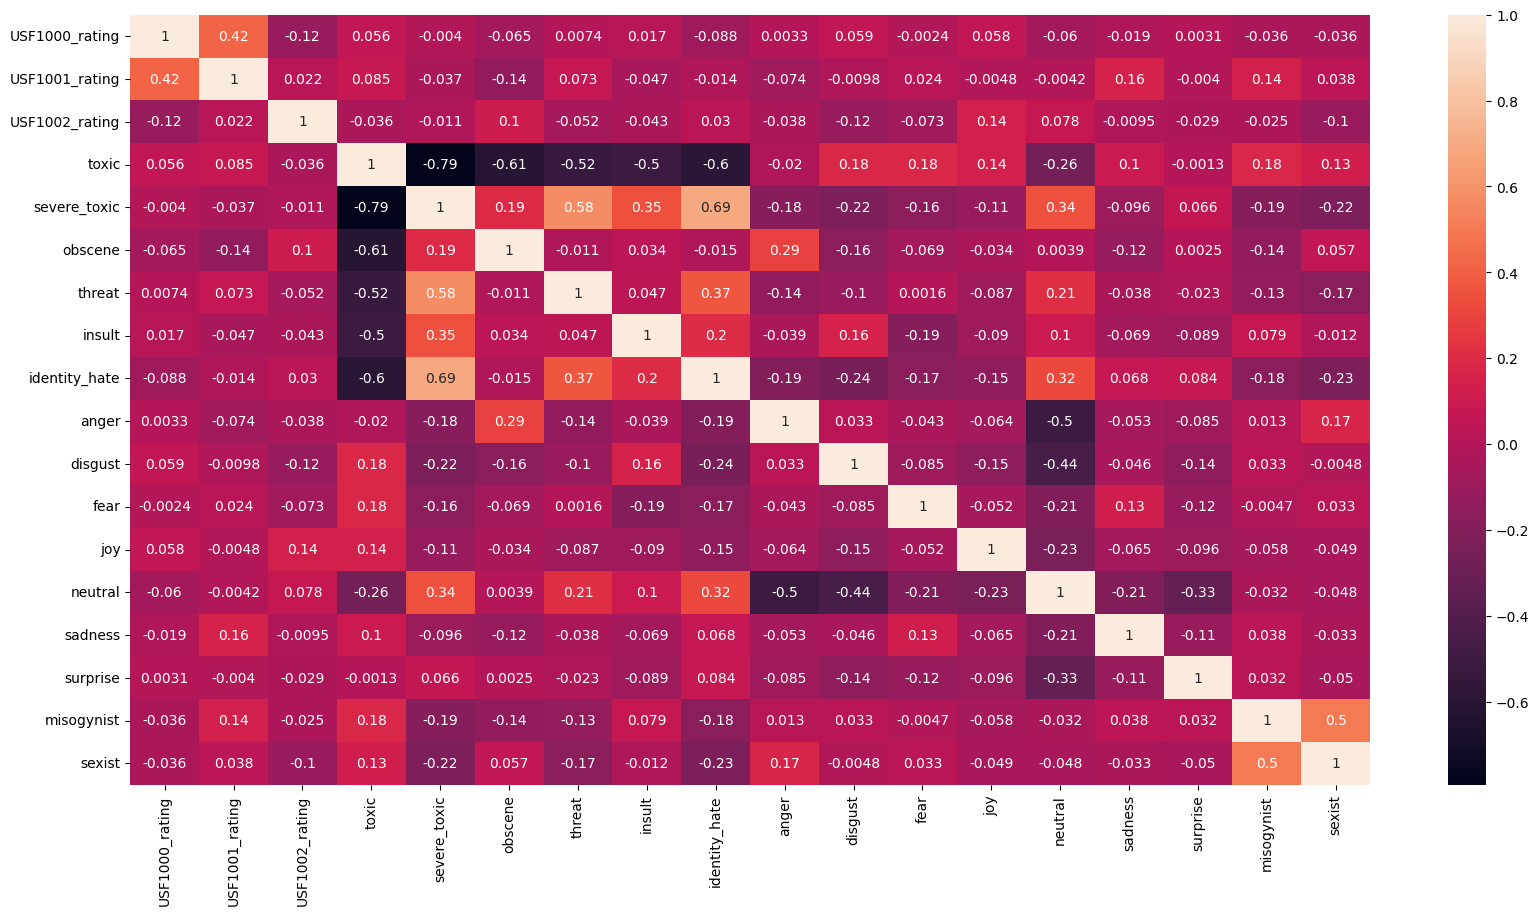

In [43]:

plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)

In [45]:
users = pandas.read_csv('../datasets/users.csv')
users

,user_id,name,age,gender,ethnicity,country,location
0,USF1000,Tanya,24,Female,South East Asian,India,San Francisco
1,USF1001,rishab,26,Male,South East Asian,India,San Francisco
2,USF1002,Parisa,26,Female,Middle Eastern,Iran,San Francisco


In [46]:
df.head(10)

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,toxic,severe_toxic,obscene,...,identity_hate,anger,disgust,fear,joy,neutral,sadness,surprise,misogynist,sexist
0,RE5tz52q,1,8,0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0.948757,0.001940,0.017464,...,0.010501,0.061078,0.877237,0.007832,0.003182,0.035944,0.006267,0.008462,0.000283,0.009227
1,RE5tz4dd,1,8,0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0.740485,0.004393,0.015876,...,0.203930,0.002969,0.014989,0.029352,0.001861,0.020232,0.835095,0.095502,0.000188,0.010509
2,RE5tz319,0,9,8,reddit,5tz319,I recently went to America....\n...and being t...,0.713799,0.033521,0.078657,...,0.061007,0.293198,0.003329,0.008355,0.498788,0.141473,0.008533,0.046325,0.000199,0.008724
3,RE5tz2wj,3,9,0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0.863763,0.006648,0.044527,...,0.030795,0.013720,0.017939,0.012250,0.079466,0.812853,0.001028,0.062745,0.000208,0.010060
4,RE5tz1pc,5,3,8,reddit,5tz1pc,You hear about the University book store worke...,0.556188,0.064266,0.102729,...,0.087984,0.143550,0.174086,0.003311,0.002103,0.041834,0.004530,0.630588,0.000153,0.006886
5,RE5tz1o1,4,4,0,reddit,5tz1o1,Why is it unknown on how pterodactyls urinate ...,0.866577,0.009057,0.037896,...,0.023799,0.001877,0.064879,0.003407,0.001246,0.900958,0.003667,0.023965,0.000339,0.011149
6,RE5tz0ef,0,7,0,reddit,5tz0ef,Why women need legs?\nTo avoid leaving tracks ...,0.921056,0.001924,0.010570,...,0.035181,0.003451,0.006644,0.007341,0.001395,0.938245,0.001607,0.041317,0.999836,0.823058
7,RE5tz04j,2,5,9,reddit,5tz04j,I walked into a PETA adoption center and the r...,0.648270,0.043656,0.090609,...,0.070303,0.003184,0.035175,0.005441,0.002587,0.944953,0.002504,0.006156,0.000839,0.014991
8,RE5tz02q,3,3,0,reddit,5tz02q,How did TV studios make words appear on screen...,0.547692,0.065443,0.106863,...,0.087243,0.007832,0.001307,0.003889,0.020206,0.130116,0.000390,0.836259,0.003367,0.008560
9,RE5tz02h,0,7,3,reddit,5tz02h,How do you find Will Smith in the snow?\nYou f...,0.713043,0.033876,0.055101,...,0.069709,0.003407,0.001953,0.001020,0.001523,0.983160,0.000477,0.008460,0.000195,0.007716


In [53]:
users_encoded = users.copy()
users_encoded = users_encoded.drop(columns=['name', 'user_id'], axis=1)
users_encoded['age'] = users['age'].astype(str)
users_encoded = pandas.get_dummies(users_encoded)
users_encoded

,age_24,age_26,gender_Female,gender_Male,ethnicity_Middle Eastern,ethnicity_South East Asian,country_India,country_Iran,location_San Francisco
0,1,0,1,0,0,1,1,0,1
1,0,1,0,1,0,1,1,0,1
2,0,1,1,0,1,0,0,1,1


In [54]:
users_demographics = df.copy()
for index, row in df.iterrows():
    for col in users_encoded.columns:
        sum = 0
        # number_of_users is the number of rows in users_encoded
        number_of_users = len(users_encoded.index)
        for user_id in range(number_of_users):
            weight = users_encoded.at[user_id, col]
            rating = df.at[index, f'USF100{user_id}_rating']
            sum += weight * rating
        users_demographics.at[index, col] = sum / (number_of_users * 10)
users_demographics

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,toxic,severe_toxic,obscene,...,sexist,age_24,age_26,gender_Female,gender_Male,ethnicity_Middle Eastern,ethnicity_South East Asian,country_India,country_Iran,location_San Francisco
0,RE5tz52q,1,8,0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0.948757,0.001940,0.017464,...,0.009227,0.033333,0.266667,0.033333,0.266667,0.000000,0.300000,0.300000,0.000000,0.300000
1,RE5tz4dd,1,8,0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0.740485,0.004393,0.015876,...,0.010509,0.033333,0.266667,0.033333,0.266667,0.000000,0.300000,0.300000,0.000000,0.300000
2,RE5tz319,0,9,8,reddit,5tz319,I recently went to America....\n...and being t...,0.713799,0.033521,0.078657,...,0.008724,0.000000,0.566667,0.266667,0.300000,0.266667,0.300000,0.300000,0.266667,0.566667
3,RE5tz2wj,3,9,0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0.863763,0.006648,0.044527,...,0.010060,0.100000,0.300000,0.100000,0.300000,0.000000,0.400000,0.400000,0.000000,0.400000
4,RE5tz1pc,5,3,8,reddit,5tz1pc,You hear about the University book store worke...,0.556188,0.064266,0.102729,...,0.006886,0.166667,0.366667,0.433333,0.100000,0.266667,0.266667,0.266667,0.266667,0.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,SS200,8,10,4,stupidstuff,200,A concerned husband went to a doctor to talk a...,0.798498,0.016582,0.065758,...,0.101227,0.266667,0.466667,0.400000,0.333333,0.133333,0.600000,0.600000,0.133333,0.733333
187,SS5,0,0,0,stupidstuff,5,A girl came skipping home FROM school one day....,0.836141,0.002367,0.027253,...,0.216950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
188,SS6,0,0,0,stupidstuff,6,An airline captain was helping a new blonde fl...,0.570222,0.061703,0.110768,...,0.090076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
189,SS7,0,0,0,stupidstuff,7,A blonde and a brunette decided to rob a bank....,0.566404,0.005902,0.176181,...,0.506783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/var/folders/4s/j6kkydzj71j0kv5d90zqxz5w0000gn/T/ipykernel_16939/947256376.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(users_demographics.corr(), annot=True)


<AxesSubplot: >

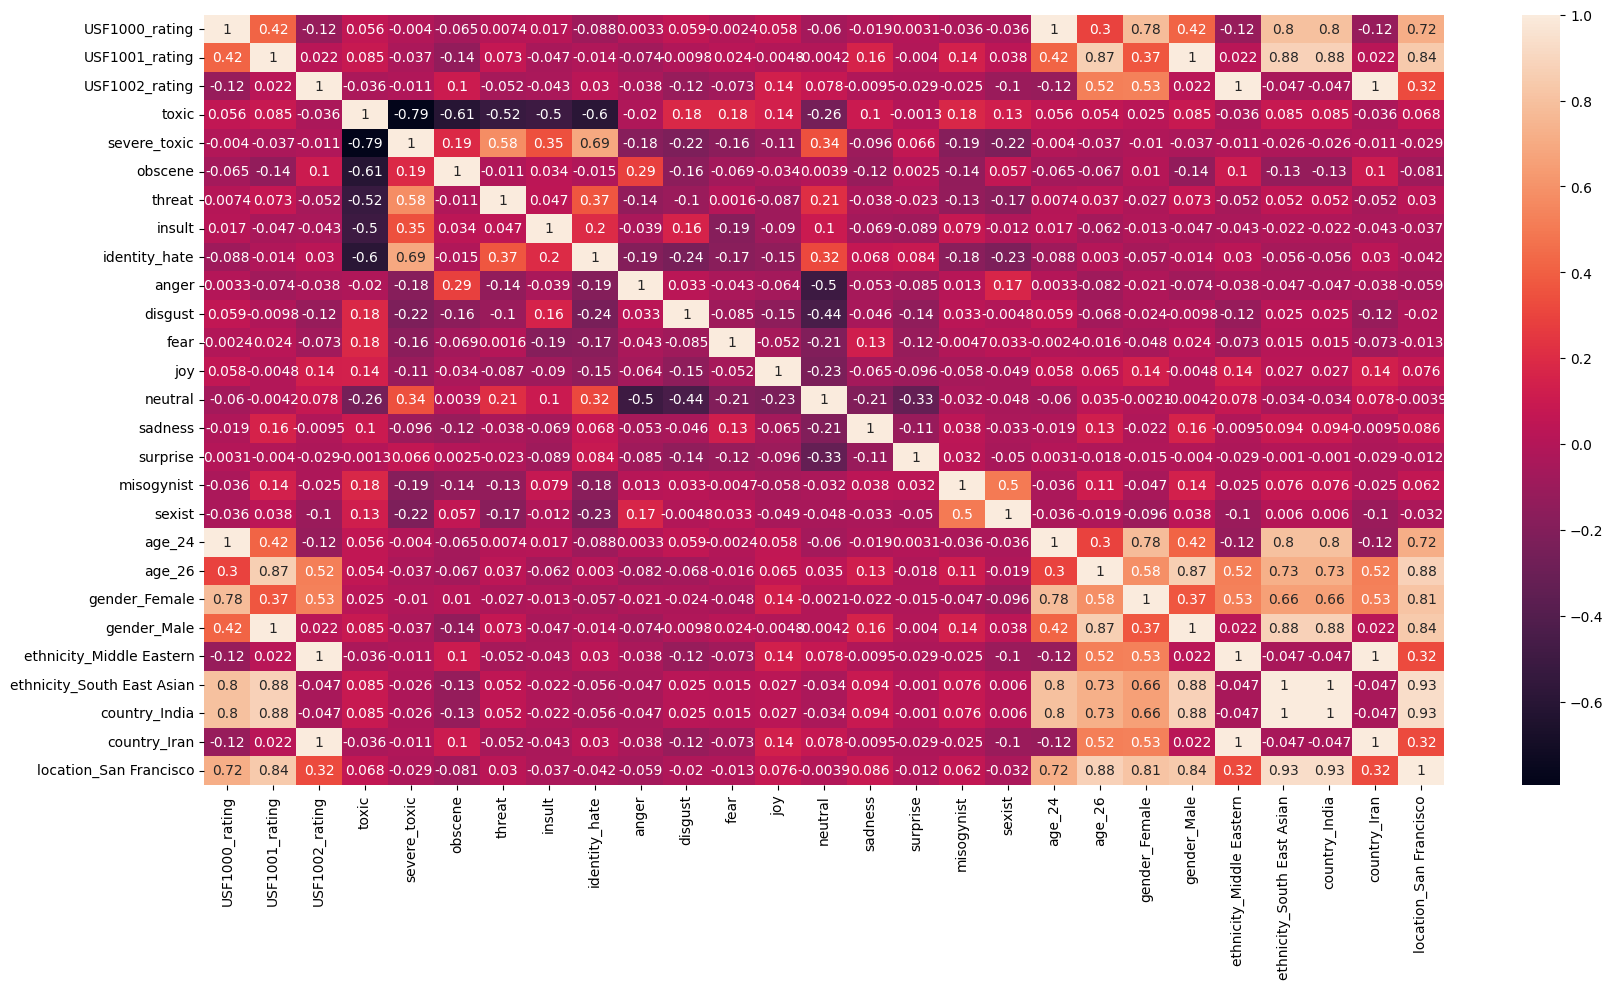

In [55]:
plt.figure(figsize=(20,10))
sns.heatmap(users_demographics.corr(), annot=True)